In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Common imports
import os


In [4]:
import transform_helper
%aimport transform_helper

# Create plots for Fundamental Assumption
ssm = transform_helper.StockPrice_shiftedMean_Helper()
ss_df = ssm.gen_prices(.001, .02, [10, 20], num_returns=252)
fig_data, axs_data = ssm.plot_data(ss_df, visible=False)
fig_segs, axs_segs = ssm.plot_segments(ss_df, visible=False)

In [5]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

# Formula for surface as function of X and Y
def func_call(X, Y):
    Z = np.zeros_like(X) + 2
    Z += 0.1 * np.sin(.35*X)*np.cos(.35*Y)

    return Z

def draw_surface(n_points = 100, title='Complex surface $f(x_1, x_2)$'):
    # Create a grid of points
    x = np.linspace(0, 10, n_points)
    y = np.linspace(0, 10, n_points)
    X, Y = np.meshgrid(x, y)

    # Calculate option prices
    Z = func_call(X, Y)

    # Create figure with 3 subplots
    fig = plt.figure(figsize=(12, 10))

    # Plot 1: Basic surface
    ax = fig.add_subplot(111, projection='3d')
    surface1 = ax.plot_surface(X, Y, Z, cmap='viridis',  alpha=0.7)

    # Add a title
    ax.set_title(title, fontsize=20)

    # Limit the z-axis so as to fill the area
    ax.set_zlim(1.75,2.25)
    
    # Label the axes
    ax.set_xlabel("$x_1$", fontsize=16)
    ax.set_ylabel("$x_2$", fontsize=16)
    ax.set_zlabel("$f(x_1, x_2)$", fontsize=16)

    #fig.colorbar(surface1, ax=ax, shrink=0.5, aspect=5)
    
    return fig, ax, X, Y, Z

def add_random(fig, ax, X,Y, xmin, xmax, ymin, ymax, n_points=100):
    # Create masks
    X_mask = (X >= xmin) & (X <= xmax)
    Y_mask = (Y >= ymin) & (Y <=ymax)

    # Combine masks to get points in upper quartile for both K and T
    combined_mask = X_mask & Y_mask

    # Get the indices of points in the upper quartile
    restricted_indices = np.where(combined_mask.flatten())[0]

    # Generate n_points random points from the upper quartile
    random_indices = np.random.choice(restricted_indices, n_points, replace=False)

    X_random = X.flatten()[random_indices]
    Y_random = Y.flatten()[random_indices]
    Z_random = Z.flatten()[random_indices]
    ax.scatter(X_random, Y_random, Z_random, c='red', s=50, marker='o')

    return fig, ax

def add_shaded(fig, ax, xmin, xmax, ymin, ymax):
    # Define the vertices of the shaded area polygon
    zmin = ax.get_zlim()[0]
    verts = [(xmin, ymin, zmin), (xmax, ymin, zmin), (xmax, ymax, zmin), (xmin, ymax, zmin)]

    # Create a Poly3DCollection and add it to the plot
    poly = Poly3DCollection([verts], alpha=0.5, facecolors='grey')
    ax.add_collection3d(poly)
    
    return fig, ax

# Recipe "Get the data" step: subtleties

In describing the "Get the data" step
- we hinted at the *mechanical* difficulties of gathering examples

Beyond these difficulties, it is important that 
- the examples used in training
    - and for evaluating the Performance Metric: test examples
- should be representative of the "out of sample" examples on which we want to predict in the future

We motivate this statement below.

# Fundamental assumption of Machine Learning

Our goal is to learn (from training examples) to make a good prediction on a never before seen *test* example.

A necessary condition is that the training examples are representative of the future test examples we will encounter.

Let's imagine that there is some true (but unknown) distribution $\pdata$ of feature/label pairs $(\x, \y)$.

In order to learn, we must assume
- The *training examples* are a sample drawn from $\pdata$.
- Each "out of sample" example that will occur *post-training* is drawn from $\pdata$

We sometimes call the training data an *empirical* distribution -- it is just a sample, not the "true" distribution.

Let's imagine a complex distribution where the target is a function of two features
$$\y = f(\x_1, \x_2)$$

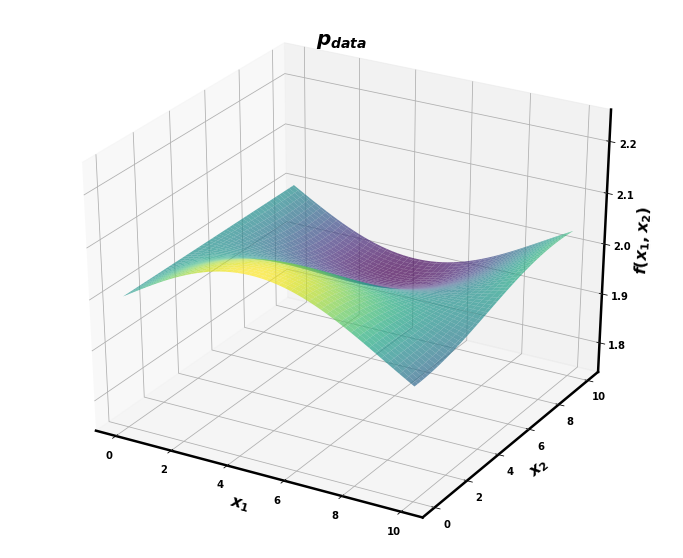

In [6]:
fig, ax, X, Y, Z = draw_surface(title='$p_{data}$')

But suppose our training examples where drawn *only from a small subset* of $\Reals \times \Reals $

We would 
- might learn to successfully predict *only* from the subset represented in the training dataset.
- have no guarantee as to the values predicted for feature vectors $\x$ very different than those in the training dataset


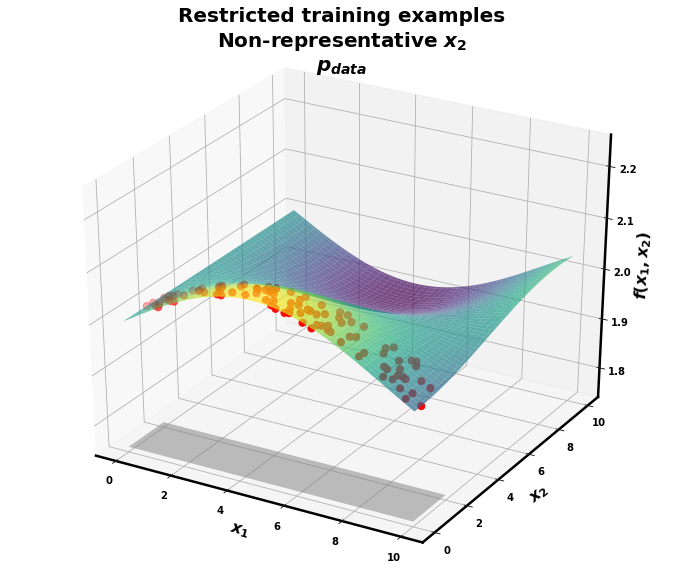

In [7]:
fig, ax, X, Y, Z = draw_surface(title='Restricted training examples\nNon-representative $x_2$\n$p_{data}$')

_, _ = add_random(fig, ax, X, Y, 0, X.max(), 0, 2)
_, _ = add_shaded(fig, ax, 0, X.max(), 0, 2)

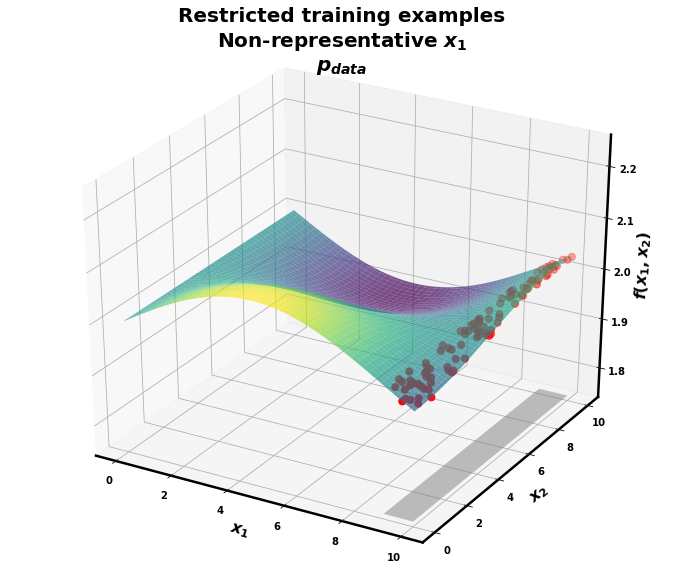

In [8]:
fig, ax, X, Y, Z = draw_surface(title='Restricted training examples\nNon-representative $x_1$\n$p_{data}$')

_, _ = add_random(fig, ax, X, Y, 9, X.max(), 0, Y.max())
_, _ = add_shaded(fig, ax, 9, X.max(), 0, Y.max())

In order to successfully predict over a representative range of $\Reals \times \Reals$
- the training examples should be sufficiently diverse

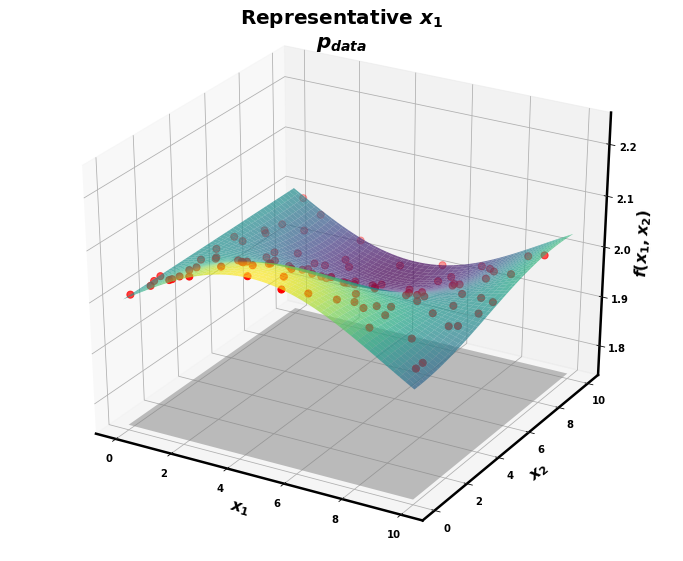

In [9]:
fig, ax, X, Y, Z = draw_surface(title='Representative $x_1$\n$p_{data}$')

_, _ = add_random(fig, ax, X, Y, X.min(), X.max(), Y.min(), Y.max())
_, _ = add_shaded(fig, ax, X.min(), X.max(), Y.min(), Y.max())

That is: our model can only generalize based on training examples
- The training examples need to be representative of unseen examples in the wild in order to generalize well
- Larger training sets are preferred as they may be more representative of the true $\pdata$
    - They should also be diverse
    
If the test example $\x$ is $not$ from $\pdata$, the model is unconstrained in its prediction.,

# Fundamental Assumption: Finance

You should not take for granted the satisfaction of this assumption !
- It is very easy in Finance
- to inadvertently collect *non-representative* examples

Suppose we want to predict the future price of a stock using only past prices.

Consider the following price series:

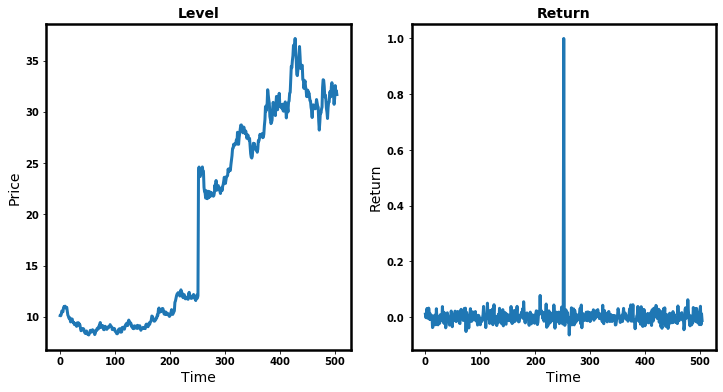

In [10]:
fig_data

From the Price Levels, you can see that there is a one-time jump in prices.

If your training examples were from the time before the jump and your "future" test examples were from after the jump
- the examples don't come from the same Price distribution
    - at a minimum: the mean prices are different
- using Price/Level as features/targets
    - can easily lead to violations of the Fundamental Assumption

Fortunately
- there is often a simple *transformation* of raw features/targets
- into synthetic features/targets
- that *will* satisfy the Fundamental Assumption.

Let's examine
- the distribution of *returns* 
- before and after the price jump


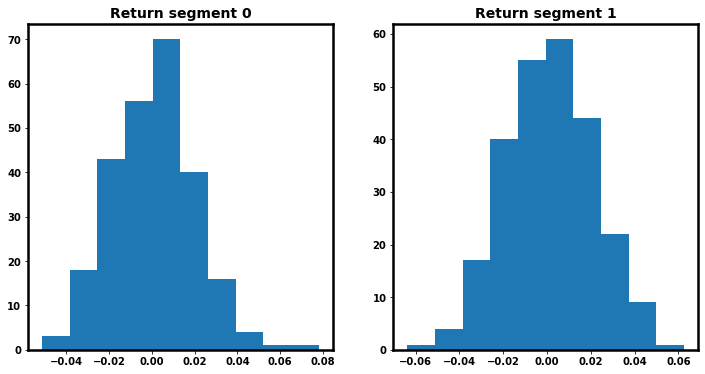

In [11]:
fig_segs

Very well could be the same (we can test for equality of moments to be sure).

So training a model to predict future returns from past returns
- Would satisfy the assumption
- We can readily convert from returns back to levels

**Aside**

Price jumps happen for many reasons.  
- New product introduction
- New business model
- Dividend payout
- Company is the target of a take-over offer

A more frequent scenario is that data drifts over time rather than jumping suddenly.

Whatever the cause, we need to induce some stability over the data.
- returns are more stable than prices

# Recipe "Prepare the data/Transformations" step

This example illustrates another point.

Sometimes a *raw feature/target* (e.g., Level) need to be *transformed* into a synthetic feature/target (e.g. Return).

A successful Data Scientist needs to master the process of transforming data
- The "secrets" that need to be uncovered might not lie at the surface


The Recipe's "Transformation" step (sub-step of "Prepare the Data")
- is where raw features/targets
- are *transformed* into synthetic features/targets
- which may have more desirable properties for prediction
    - e.g., satisfy Fundamental Assumption
    

As we will see
- this step can also add new synthetic features
- drop features

Transformations are a very important part of Data Science
- to be covered in a future module

In [12]:
print("Done")

Done
